In [ ]:
!pip install opencv-python numpy tensorflow scikit-learn matplotlib seaborn tqdm
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
!wget --no-check-certificate "https://www.crcv.ucf.edu/data/UCF101/UCF101.rar"
!apt-get install unrar -y
!unrar x UCF101.rar
!mv UCF-101 UCF101  # Rename extracted folder

dataset_path = "UCF101"
print(f"Total Action Classes: {len(os.listdir(dataset_path))}")
print(f"Sample Classes: {os.listdir(dataset_path)[:5]}")

Streaming output truncated to the last 5000 lines.
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c07.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c01.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c02.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c03.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c04.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c05.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c06.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c07.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g08_c01.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g08_c02.avi             62%  OK 
Extracting  UCF-101/PlayingGu

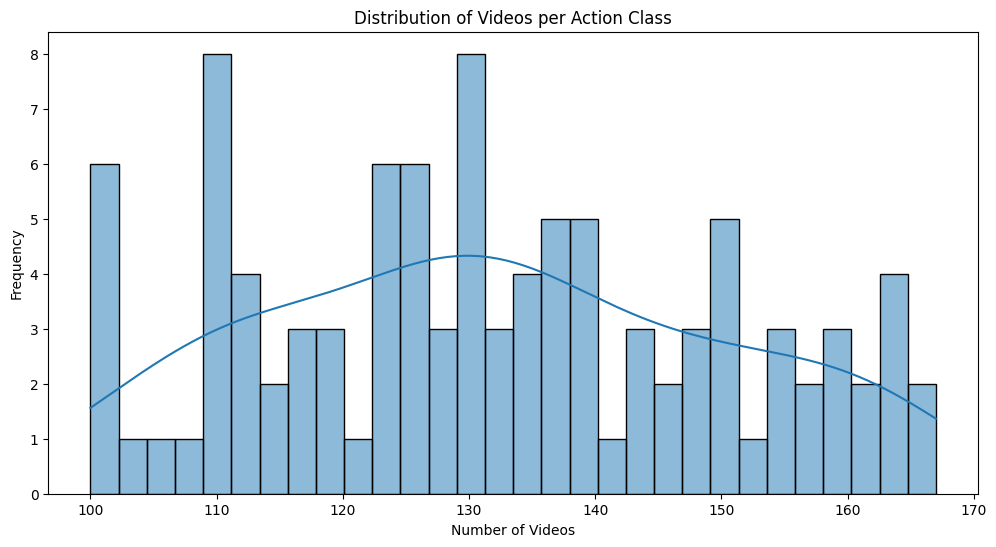

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns
import os


dataset_path = "UCF101"

# Count the number of videos per class
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):  # Check if it's a directory
        class_counts[class_name] = len(os.listdir(class_path))

# Create the plot
plt.figure(figsize=(12, 6))
sns.histplot(list(class_counts.values()), bins=30, kde=True)
plt.title('Distribution of Videos per Action Class')
plt.xlabel('Number of Videos')
plt.ylabel('Frequency')
plt.show()


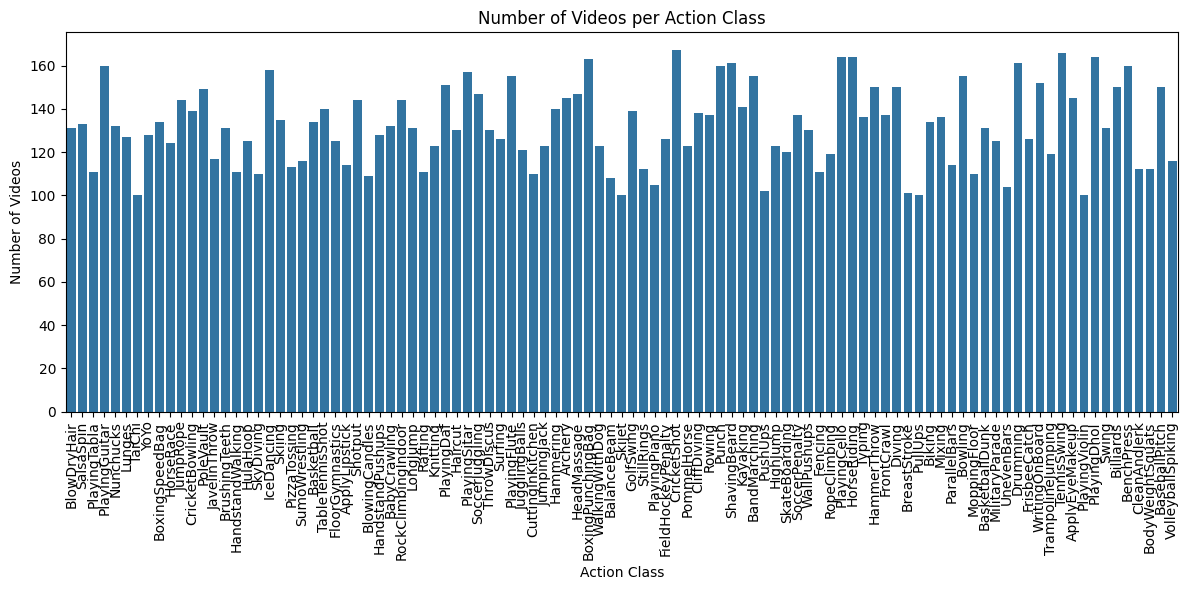

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns



plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Number of Videos per Action Class')
plt.xlabel('Action Class')
plt.ylabel('Number of Videos')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()


In [ ]:
frame_output_dir = "frames"
os.makedirs(frame_output_dir, exist_ok=True)

def extract_frames(video_path, max_frames=20, resize=(112, 112)):
    """Extract frames from video and resize them"""
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, resize)  # Reduce size to save memory
        frame = img_to_array(frame) / 255.0  # Normalize
        frames.append(frame)
        frame_count += 1

    cap.release()

    while len(frames) < max_frames:
        frames.append(np.zeros((112, 112, 3)))  # Padding if needed

    return np.array(frames)

# Example: Extract frames from one video
sample_video = os.path.join(dataset_path, "ApplyEyeMakeup", "v_ApplyEyeMakeup_g01_c01.avi")
frames = extract_frames(sample_video)
print("Extracted Frames Shape:", frames.shape)

Extracted Frames Shape: (20, 112, 112, 3)


In [ ]:
feature_output_dir = "features"
os.makedirs(feature_output_dir, exist_ok=True)

# Load CNN Model for feature extraction
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(112, 112, 3))
cnn = tf.keras.Sequential([base_model, tf.keras.layers.GlobalAveragePooling2D()])

def extract_features(video_path):
    """Extract features from video using CNN"""
    frames = extract_frames(video_path)
    features = cnn.predict(frames, verbose=0)
    return features

# Process all videos and save features
for action in tqdm(os.listdir(dataset_path), desc="Processing Classes"):
    action_path = os.path.join(dataset_path, action)
    if not os.path.isdir(action_path):
        continue

    action_feature_path = os.path.join(feature_output_dir, action)
    os.makedirs(action_feature_path, exist_ok=True)

    for video_name in os.listdir(action_path):
        if not video_name.endswith(".avi"):
            continue

        video_path = os.path.join(action_path, video_name)
        feature_path = os.path.join(action_feature_path, video_name.replace(".avi", ".npy"))

        if os.path.exists(feature_path):
            continue  # Skip if already processed

        features = extract_features(video_path)
        np.save(feature_path, features)  # Save as .npy file to save memory

print("Feature extraction completed!")

<ipython-input-4-1aaf770689f8>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(112, 112, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Processing Classes: 100%|██████████| 101/101 [22:17<00:00, 13.25s/it]

Feature extraction completed!


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  # This generator efficiently feeds batches of preprocessed features and labels into a neural network during training, reducing memory usage
    """Dynamically loads data in batches"""
    def __init__(self, feature_dir, label_encoder, batch_size=8, shuffle=True):  # Fixed __init__
        self.feature_dir = feature_dir
        self.classes = sorted(os.listdir(feature_dir))
        self.label_encoder = label_encoder
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.file_paths, self.labels = self._load_file_paths()
        self.on_epoch_end()

    def _load_file_paths(self):
        file_paths = []
        labels = []
        for class_name in self.classes:
            class_dir = os.path.join(self.feature_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            for file in os.listdir(class_dir):
                if file.endswith(".npy"):
                    file_paths.append(os.path.join(class_dir, file))
                    labels.append(class_name)

        if len(file_paths) == 0:
            raise FileNotFoundError("No .npy files found!")

        return file_paths, self.label_encoder.transform(labels)

    def __len__(self):  # Fixed __len__
        return len(self.file_paths) // self.batch_size

    def __getitem__(self, index):  # Fixed __getitem__
        batch_paths = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        batch_features = [np.load(path) for path in batch_paths]
        batch_features = np.array(batch_features)

        return batch_features, np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.file_paths, self.labels))
            np.random.shuffle(temp)
            self.file_paths, self.labels = zip(*temp)

print("Data generator is ready!")

Data generator is ready!


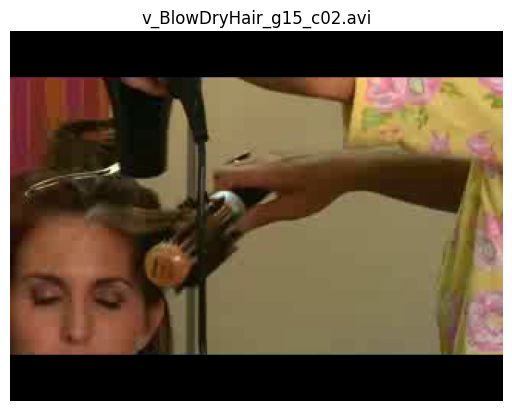

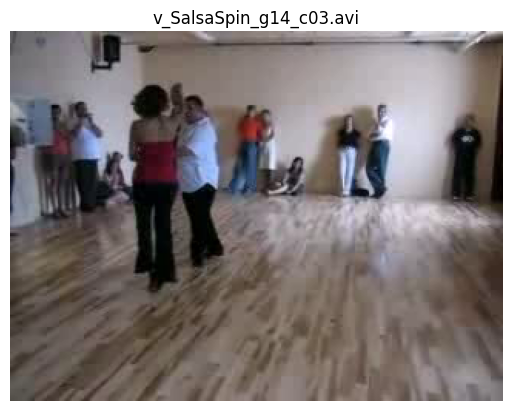

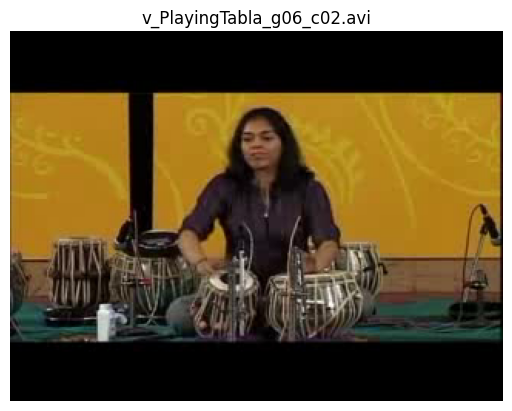

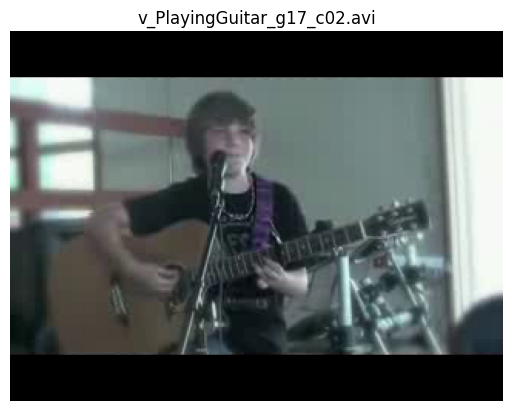

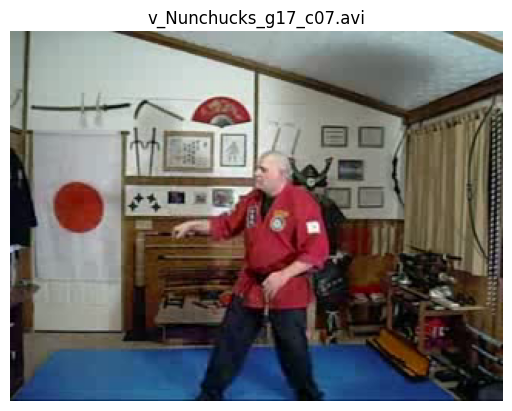

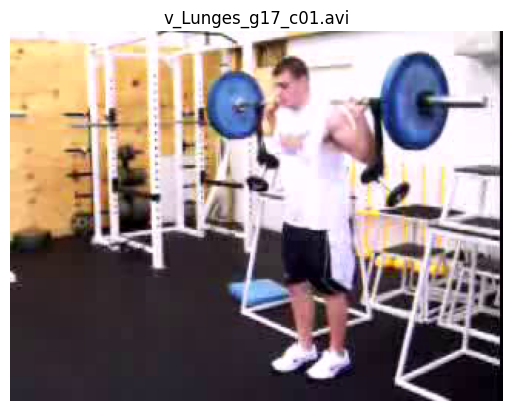

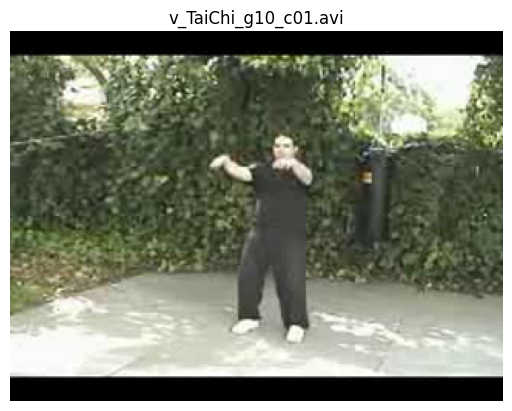

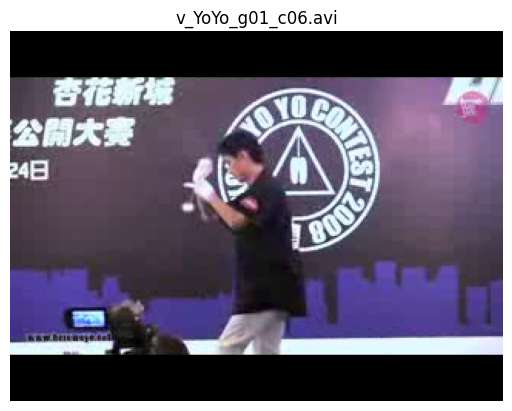

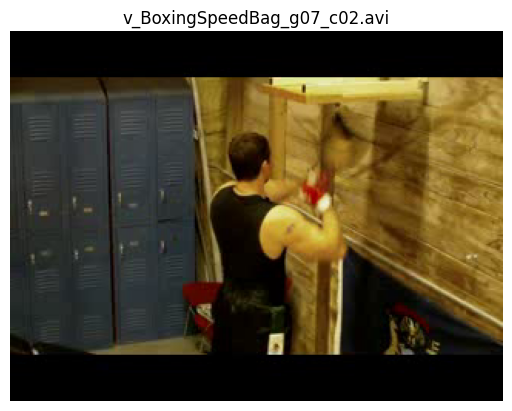

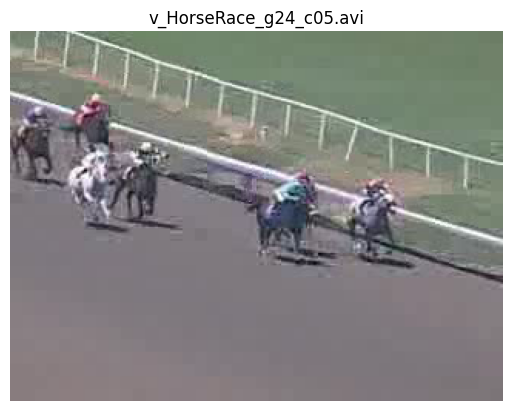

In [ ]:


import matplotlib.pyplot as plt
import cv2
import os


dataset_path = "UCF101"

# Function to display a video
def display_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return

    ret, frame = cap.read()
    if not ret:
        print(f"Error reading frame from: {video_path}")
        return

    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for display
    plt.title(os.path.basename(video_path))
    plt.axis('off')
    plt.show()
    cap.release()


# Display a few sample videos
sample_classes = os.listdir(dataset_path)[:10]  # Get first 3 classes
for class_name in sample_classes:
  class_path = os.path.join(dataset_path, class_name)
  if os.path.isdir(class_path):
    video_files = [f for f in os.listdir(class_path) if f.endswith(('.avi', '.mp4'))]
    if video_files:
        sample_video = os.path.join(class_path, video_files[0])
        display_video(sample_video)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(sorted(os.listdir(feature_output_dir)))

# Load data using generator
batch_size = 8
train_generator = DataGenerator(feature_output_dir, label_encoder, batch_size=batch_size)
val_generator = DataGenerator(feature_output_dir, label_encoder, batch_size=batch_size, shuffle=False)

# CNN+LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(20, 1280)),  # Adjust shape based on MobileNetV2
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dense(len(label_encoder.classes_), activation="softmax")  # Output layer
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 20, 128)             │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 101)                 │           6,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 781,541 (2.98 MB)

 Trainable params: 781,541 (2.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history=model.fit(train_generator, validation_data=val_generator, epochs=30)

Epoch 1/30
1664/1665 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0466 - loss: 4.2298

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1665/1665 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.0467 - loss: 4.2294 - val_accuracy: 0.1979 - val_loss: 3.0430
Epoch 2/30
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.2103 - loss: 2.9750 - val_accuracy: 0.3715 - val_loss: 2.2824
Epoch 3/30
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.3501 - loss: 2.3103 - val_accuracy: 0.4956 - val_loss: 1.7903
Epoch 4/30
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.4642 - loss: 1.8824 - val_accuracy: 0.5520 - val_loss: 1.5449
Epoch 5/30
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.5412 - loss: 1.5835 - val_accuracy: 0.6380 - val_loss: 1.2358
Epoch 6/30
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - accuracy: 0.6050 - loss: 1.3493 - val_accuracy: 0.6824 - val_loss: 1.0592
Epoch 7/30
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.6496 - loss: 1.1777 - val_accuracy: 0.7556 - val_loss: 0.8270
Epoch 8/30
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.7125 - loss: 0.97

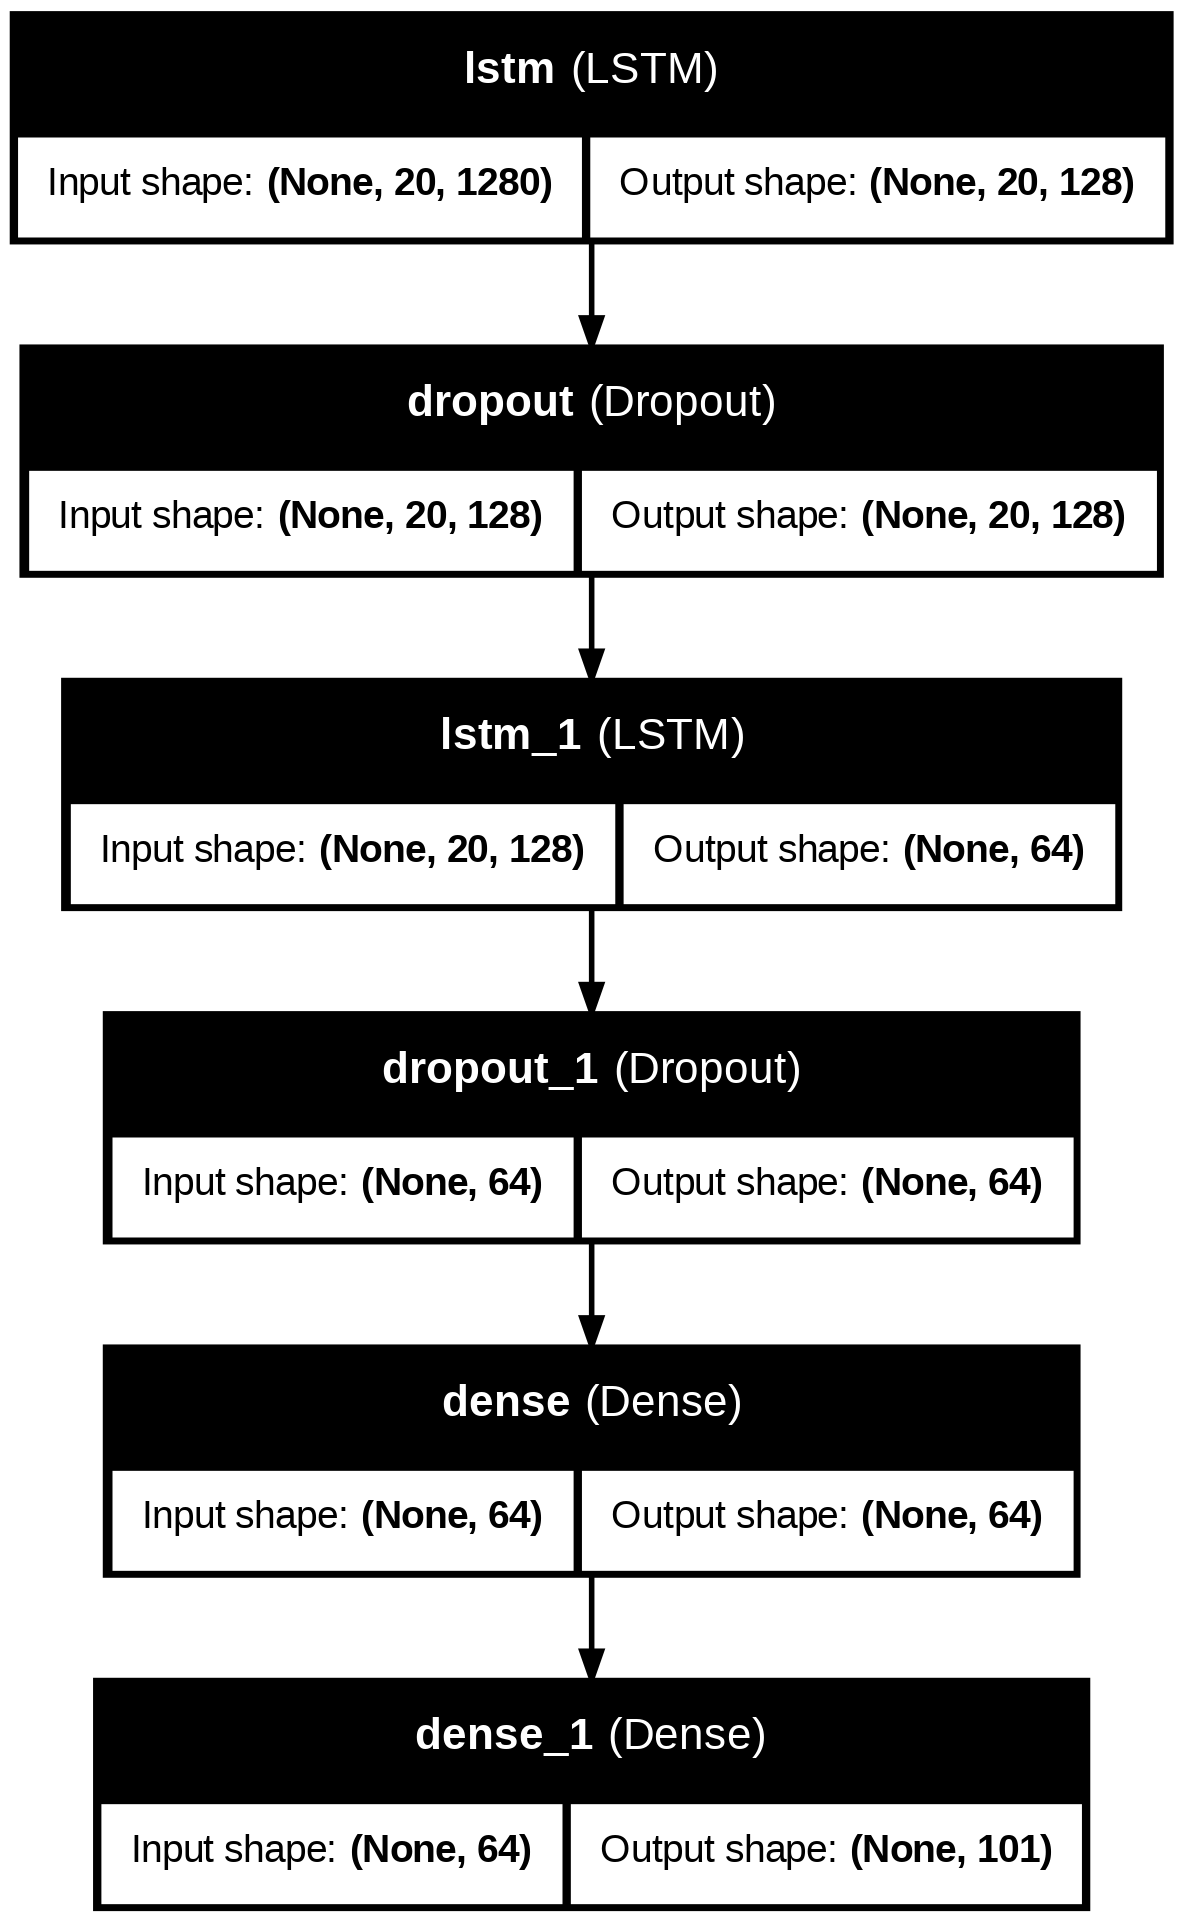

In [ ]:


from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)


In [ ]:
loss, accuracy = model.evaluate(val_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

1665/1665 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9721 - loss: 0.0948
Test Accuracy: 97.42%


In [ ]:
def predict_activity(video_path):
    """Predict the action class of a given video."""

    # Extract frames
    frames = extract_frames(video_path)

    # Extract features using CNN
    features = cnn.predict(frames, verbose=0)

    # Reshape for LSTM input
    features = np.expand_dims(features, axis=0)  # Shape (1, 20, 1280)

    # Predict with LSTM
    prediction = model.predict(features)

    # Get class with highest probability
    predicted_class = np.argmax(prediction)
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    print(f"Predicted Activity: {predicted_label}")
    return predicted_label

# =============================== #
# ⿥ Select a Video and Predict
# =============================== #
sample_video = os.path.join("UCF101", "ApplyEyeMakeup", "v_ApplyEyeMakeup_g01_c01.avi")  # Change to any video path
predicted_label = predict_activity(sample_video)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Predicted Activity: ApplyEyeMakeup


In [ ]:
def predict_activity(video_path):
    """Predict the action class of a given video."""

    # Extract frames
    frames = extract_frames(video_path)

    # Extract features using CNN
    features = cnn.predict(frames, verbose=0)

    # Reshape for LSTM input
    features = np.expand_dims(features, axis=0)  # Shape (1, 20, 1280)

    # Predict with LSTM
    prediction = model.predict(features)

    # Get class with highest probability
    predicted_class = np.argmax(prediction)
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    print(f"Predicted Activity: {predicted_label}")
    return predicted_label

# =============================== #
# ⿥ Select a Video and Predict
# =============================== #
sample_video = os.path.join("UCF101", "PlayingGuitar", "v_PlayingGuitar_g07_c02.avi")  # Change to any video path
predicted_label = predict_activity(sample_video)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Activity: PlayingGuitar


In [ ]:
def predict_activity(video_path):
    """Predict the action class of a given video."""

    # Extract frames
    frames = extract_frames(video_path)

    # Extract features using CNN
    features = cnn.predict(frames, verbose=0)

    # Reshape for LSTM input
    features = np.expand_dims(features, axis=0)  # Shape (1, 20, 1280)

    # Predict with LSTM
    prediction = model.predict(features)

    # Get class with highest probability
    predicted_class = np.argmax(prediction)
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    print(f"Predicted Activity: {predicted_label}")
    return predicted_label

# =============================== #
# ⿥ Select a Video and Predict
# =============================== #
sample_video = os.path.join("UCF101", "Rafting", "v_Rafting_g21_c04.avi")  # Change to any video path
predicted_label = predict_activity(sample_video)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Activity: Rafting


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Activity: ApplyEyeMakeup


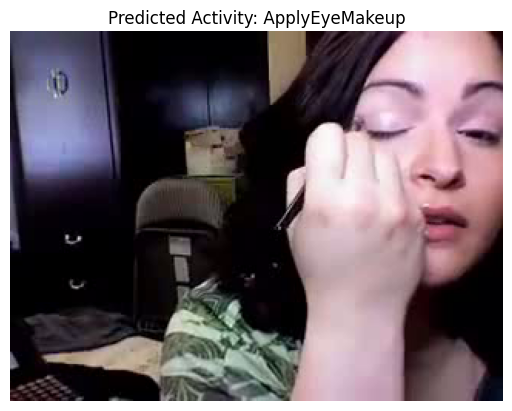

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Activity: PlayingGuitar


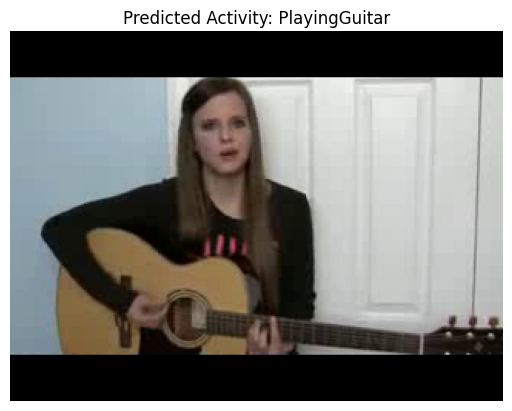

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Activity: Rafting


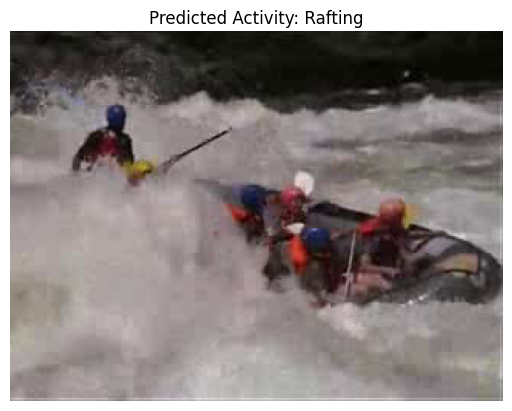

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Activity: Archery


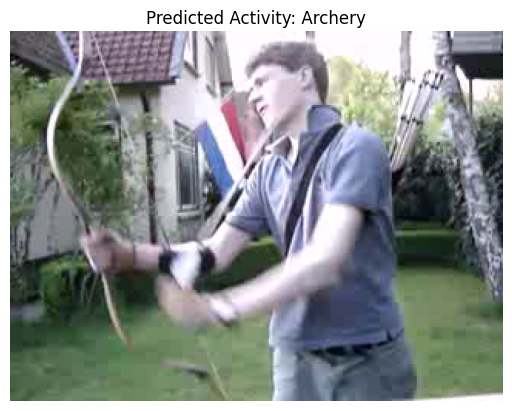

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Activity: Billiards


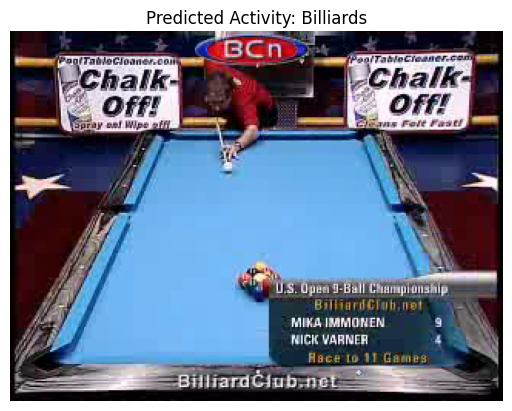

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Activity: Drumming


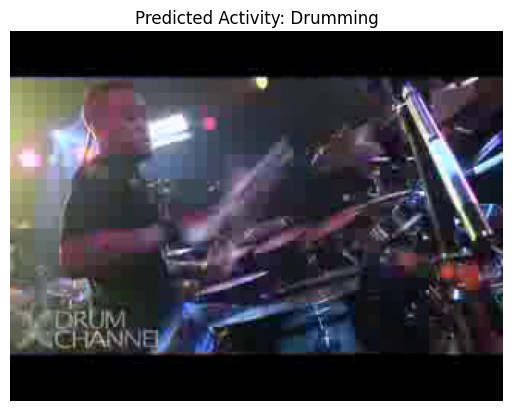

In [ ]:


import cv2
import matplotlib.pyplot as plt

def display_prediction(video_path, predicted_label):
    """Displays the video and the predicted label."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return

    ret, frame = cap.read()
    if not ret:
        print(f"Error reading frame from: {video_path}")
        return

    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted Activity: {predicted_label}")
    plt.axis('off')
    plt.show()
    cap.release()


sample_video = os.path.join("UCF101", "ApplyEyeMakeup", "v_ApplyEyeMakeup_g01_c01.avi")
predicted_label = predict_activity(sample_video)
display_prediction(sample_video, predicted_label)

sample_video = os.path.join("UCF101", "PlayingGuitar", "v_PlayingGuitar_g07_c02.avi")
predicted_label = predict_activity(sample_video)
display_prediction(sample_video, predicted_label)

sample_video = os.path.join("UCF101", "Rafting", "v_Rafting_g21_c04.avi")
predicted_label = predict_activity(sample_video)
display_prediction(sample_video, predicted_label)

sample_video = os.path.join("UCF101", "Archery", "v_Archery_g02_c01.avi")
predicted_label = predict_activity(sample_video)
display_prediction(sample_video, predicted_label)

sample_video = os.path.join("UCF101", "Billiards", "v_Billiards_g07_c02.avi")
predicted_label = predict_activity(sample_video)
display_prediction(sample_video, predicted_label)

sample_video = os.path.join("UCF101", "Drumming", "v_Drumming_g03_c03.avi")
predicted_label = predict_activity(sample_video)
display_prediction(sample_video, predicted_label)


In [ ]:
def predict_activity(video_path):
    """Predict the action class of a given video."""

    # Extract frames
    frames = extract_frames(video_path)

    # Extract features using CNN
    features = cnn.predict(frames, verbose=0)

    # Reshape for LSTM input
    features = np.expand_dims(features, axis=0)  # Shape (1, 20, 1280)

    # Predict with LSTM
    prediction = model.predict(features)

    # Get class with highest probability
    predicted_class = np.argmax(prediction)
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    print(f"Predicted Activity: {predicted_label}")
    return predicted_label

# =============================== #
# ⿥ Select a Video and Predict
# =============================== #
sample_video = os.path.join("UCF101", "TableTennisShot", "v_TableTennisShot_g19_c06.avi")  # Change to any video path
predicted_label = predict_activity(sample_video)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Activity: TableTennisShot


In [ ]:

def predict_activity(video_path):
    """Predict the action class of a given video."""

    # Extract frames
    frames = extract_frames(video_path)

    # Extract features using CNN
    features = cnn.predict(frames, verbose=0)

    # Reshape for LSTM input
    features = np.expand_dims(features, axis=0)  # Shape (1, 20, 1280)

    # Predict with LSTM
    prediction = model.predict(features)

    # Get class with highest probability
    predicted_class = np.argmax(prediction)
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    print(f"Predicted Activity: {predicted_label}")
    return predicted_label

# =============================== #
# ⿥ Select a Video and Predict
# =============================== #
sample_video = os.path.join("UCF101", "PlayingSitar", "v_PlayingSitar_g03_c06.avi")  # Change to any video path
predicted_label = predict_activity(sample_video)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Activity: PlayingSitar


1665/1665 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


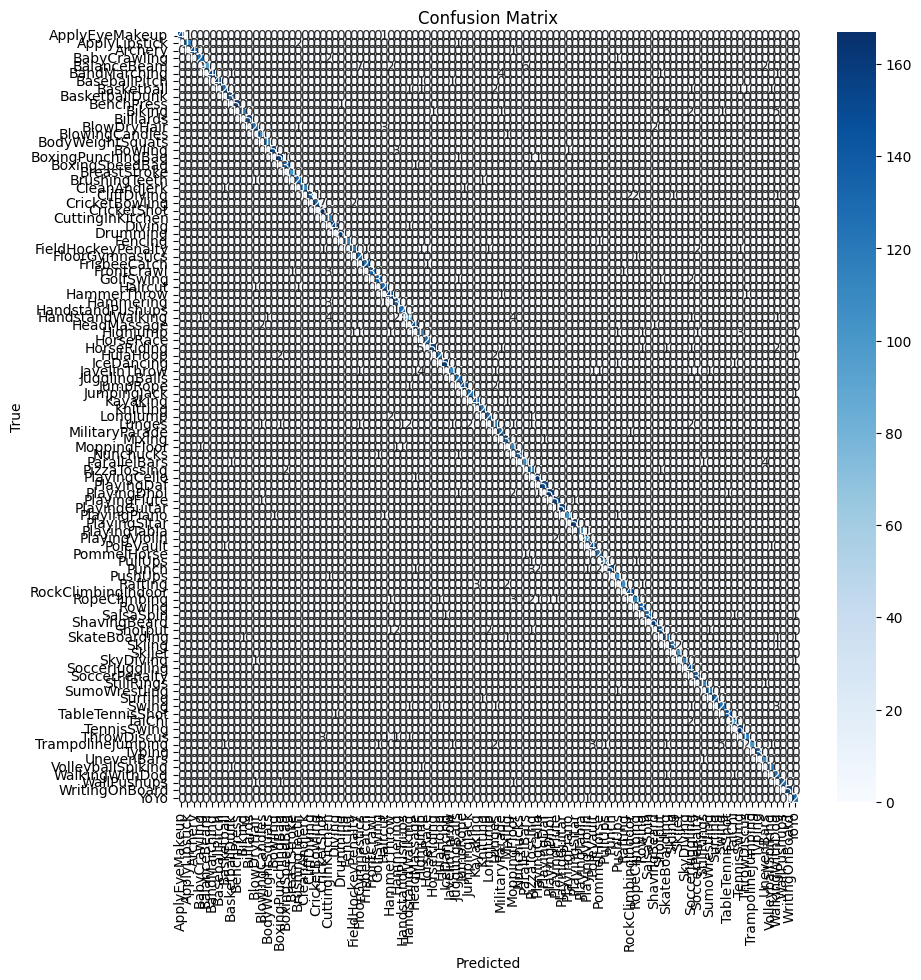

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have y_true (true labels) and y_pred (predicted labels)
# from your model evaluation.
# Replace these with your actual values.
y_true = val_generator.labels #Example
y_pred = np.argmax(model.predict(val_generator), axis=1) #Example


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


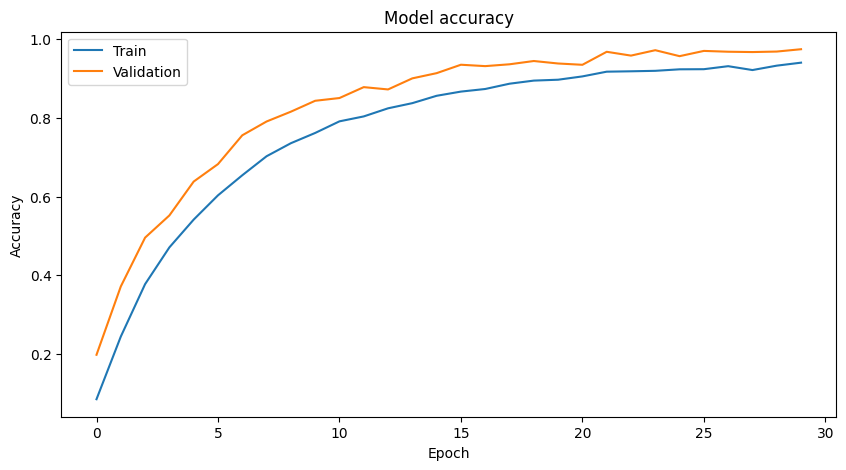

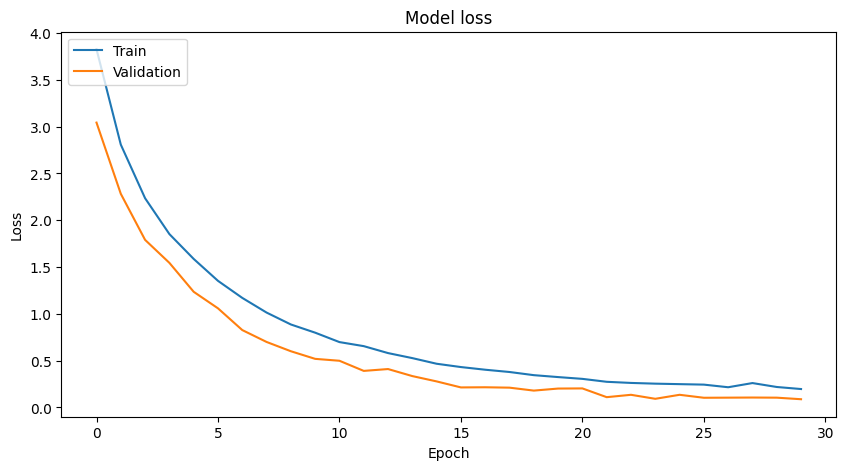

In [ ]:


import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:

import numpy as np
from sklearn.metrics import classification_report


y_true = val_generator.labels
y_pred = np.argmax(model.predict(val_generator), axis=1)

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)

report


1665/1665 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


'                    precision    recall  f1-score   support\n\n    ApplyEyeMakeup       1.00      0.99      0.99       145\n     ApplyLipstick       0.99      0.97      0.98       114\n           Archery       1.00      0.99      1.00       145\n      BabyCrawling       0.98      0.98      0.98       132\n       BalanceBeam       1.00      0.84      0.91       108\n      BandMarching       1.00      0.95      0.98       155\n     BaseballPitch       1.00      0.99      0.99       150\n        Basketball       0.98      0.94      0.96       134\n    BasketballDunk       0.98      1.00      0.99       131\n        BenchPress       1.00      0.99      1.00       160\n            Biking       0.99      0.88      0.93       134\n         Billiards       1.00      1.00      1.00       150\n       BlowDryHair       0.97      0.95      0.96       131\n    BlowingCandles       0.96      0.99      0.98       109\n  BodyWeightSquats       0.99      1.00      1.00       112\n           Bowling   